In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_windows(df, window_size, stride=1):
    windows = []
    z_score = StandardScaler()

    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i : i + window_size]

        normalized_window = z_score.fit_transform(window.iloc[:, [1]])

        windows.append(normalized_window)

    return windows


# Load Data

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')
data = pd.read_csv('/content/drive/MyDrive/AutoEncoder (on our data)/WashingMachine_PhaseCount_3_geq_2017-10-23_lt_2017-10-30.csv')

# Preprocessing

In [ ]:
my_data = data[['SensorDateTime', 'I3_A']]

In [ ]:
my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
my_data['SensorDateTime_numeric'] = my_data['SensorDateTime'].map(pd.Timestamp.timestamp)  # تبدیل به عدد
my_data = my_data[['SensorDateTime_numeric','I3_A']]

<ipython-input-6-30fc2ff89b59>:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-6-30fc2ff89b59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['SensorDateTime'] = pd.to_datetime(my_data['SensorDateTime'], format='ISO8601')  # تبدیل به تاریخ
<ipython-input-6-30fc2ff89b59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_set(window_size,stride):
  batches = create_windows(my_data,window_size=window_size,stride=stride)

  # give these for prediction
  train_data, test_data = train_test_split(batches, test_size=0.2, random_state=42)

  train_data = np.array(train_data)
  test_data = np.array(test_data)


  train_data = train_data.reshape((-1, 128, 1))
  test_data = test_data.reshape((-1, 128, 1))

  return train_data, test_data



# Visualize

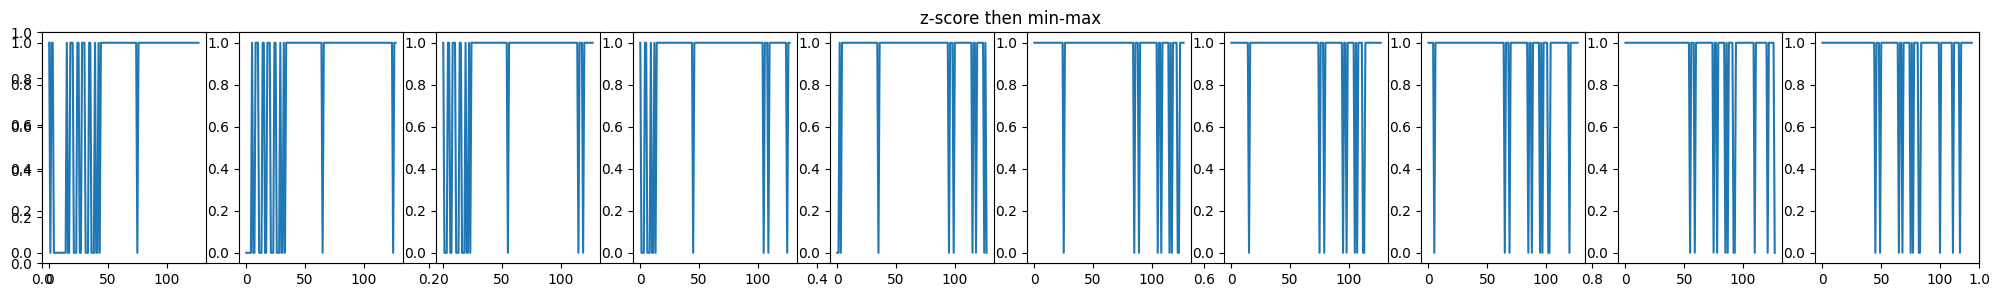

In [ ]:
plt.figure(figsize=(25, 3))

plt.title('z-score then min-max')
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.plot(standard_minmax[i])

plt.show()

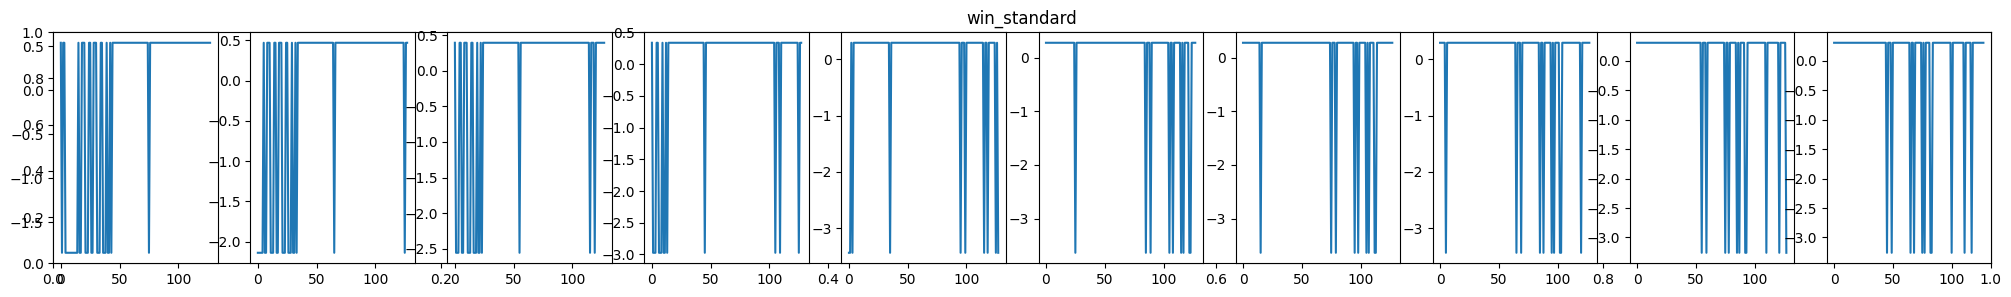

In [ ]:
# win_org = my_data.iloc[:128,1]
# win_standard = windows[2]
# win_minmax=windows_minmax[2]

plt.figure(figsize=(25,3))

plt.title('win_standard')
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.plot(windows[i])

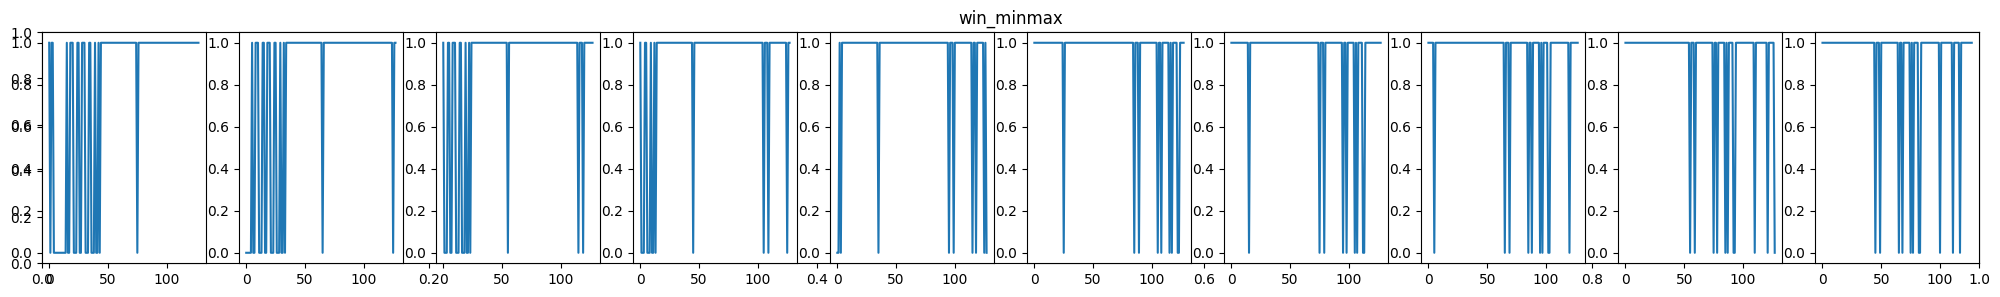

In [ ]:
plt.figure(figsize=(25,3))

plt.title('win_minmax')
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.plot(windows_minmax[i])

# VAE

## Functions

In [ ]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Pass the inputs through the encoder and then the decoder
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    # keras.losses.binary_crossentropy(data, reconstruction),
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=1,
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z)
        reconstruction_loss = ops.mean(
                ops.sum(
                    # keras.losses.binary_crossentropy(data, reconstruction),
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=1,
                )
            )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




In [ ]:
def train_vae(x_train, x_test,encoder, decoder, model_path):

  vae = VAE(encoder, decoder)
  vae.compile(optimizer=keras.optimizers.Adam())

  checkpoint_filepath = model_path
  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      # save_weights_only=True,
      monitor="val_loss",   # scale
      mode="min",           # best model with minimum val_loss
      save_best_only=True
  )
  early_stopping_callback = keras.callbacks.EarlyStopping(
      monitor='val_loss',   # scale
      # min_delta=5,      # minimum change to continue training
      patience=25,          # stop if it did not change after 30 epochs
      verbose=1,            # display info with some details
      mode='min',          # scale should decrease or increase
      restore_best_weights=True, # restore the best weights
  )
  tensorboard_callback = keras.callbacks.TensorBoard(
      log_dir="logs",
      histogram_freq=1,
  )
  vae.fit(x_train, epochs=300, batch_size=64, validation_data=x_test , callbacks=[model_checkpoint_callback, early_stopping_callback, tensorboard_callback])
  return vae


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_combined(vae, test_data, latent_dim, n=30):

    # Select n samples
    x_sample = test_data[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    # Generate random latent vectors for new images
    z_random = tf.random.normal(shape=(n, latent_dim))
    generated_samples = vae.decoder(z_random, training=False)


    fig, axs = plt.subplots(2, n, figsize=(30, 6))
    for i in range(n):
        # original data
        axs[0, i].plot(test_data[i])
        axs[0, i].axis('off')

        # Reconstructed data
        axs[1, i].plot(reconstructed[i])
        axs[1, i].axis('off')


    plt.tight_layout()
    plt.show()

def visualize_reconstructed(vae, x_test_gasf,test_data, latent_dim, n=30):
    # Select n samples
    x_sample = x_test_gasf[:n]
    # Use the VAE to reconstruct the inputs
    reconstructed = vae(x_sample, training=False)
    fig, axs = plt.subplots(1, n, figsize=(15, 10))
    for i in range(n):
        axs[i].imshow(reconstructed[i].numpy().squeeze(), cmap='gray')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


## Encoder and Decoder (Dilated-CNN)

### Reqular

In [ ]:
def encoder_dilated(latent_dim):
  encoder_input = layers.Input(shape=(128,1))

  x = layers.Conv1D(8, 3, dilation_rate=5, activation=None)(encoder_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, dilation_rate=5, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, dilation_rate=5, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(32, 3, dilation_rate=5, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(32, 3, dilation_rate=10, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(64, 3, dilation_rate=5, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(64, 3, dilation_rate=5, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU()(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(encoder_input, [z_mean, z_log_var,z], name="encoder")
  return encoder

def decoder_dilated(latent_dim):
  decoder_input = layers.Input(shape=(latent_dim,))
  x = layers.Dense(512)(decoder_input)
  x = layers.Dense(88*32)(x)
  x = layers.Reshape((88,32))(x)

  x = layers.Conv1DTranspose(32, 3, dilation_rate=4, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1DTranspose(32, 3, dilation_rate=4, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1DTranspose(16, 3, dilation_rate=4, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1DTranspose(8, 3, dilation_rate=4, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1DTranspose(1, 3, dilation_rate=4, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)



  decoder = keras.Model(decoder_input, x, name="decoder")
  return decoder


# enc = encoder_dilated(60)
# enc.summary()


dec = decoder_dilated(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          31,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2816)                │       1,444,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 88, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 96, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 96, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 104, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 104, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 104, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 112, 16)             │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 112, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_3 (Conv1DTranspose) │ (None, 120, 8)              │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 120, 8)              │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 120, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_4 (Conv1DTranspose) │ (None, 128, 1)              │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 1)              │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 1)              │              

 Total params: 1,484,373 (5.66 MB)

 Trainable params: 1,484,195 (5.66 MB)

 Non-trainable params: 178 (712.00 B)

### Stream-based

In [ ]:
def encoder_dilated_multistream(latent_dim):
  encoder_input = layers.Input(shape=(128,1))

  # stream 1 (d = 0)
  x = layers.Conv1D(8, 3, activation=None)(encoder_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(8, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.MaxPooling1D()(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(64, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.MaxPooling1D()(x)

  # stream 2 (d = 3)
  y = layers.Conv1D(8, 3, dilation_rate=3, activation=None)(encoder_input)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.Conv1D(16, 3, dilation_rate=3, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.MaxPooling1D()(y)

  y = layers.Conv1D(32, 3, dilation_rate=3, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.Conv1D(64, 3, dilation_rate=3, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.MaxPooling1D()(y)

  # stream 3 (d = 5)
  z = layers.Conv1D(8, 3, dilation_rate=5, activation=None)(encoder_input)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  z = layers.Conv1D(16, 3, dilation_rate=5, activation=None)(z)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  z = layers.MaxPooling1D()(z)

  z = layers.Conv1D(32, 3, dilation_rate=5, activation=None)(z)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  z = layers.Conv1D(64, 3, dilation_rate=5, activation=None)(z)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  f = layers.Concatenate(axis=1)([x,y,z])

  f = layers.Flatten()(f)
  f = layers.Dense(512)(f)
  f = layers.LeakyReLU()(f)

  z_mean = layers.Dense(latent_dim, name="z_mean")(f)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(f)
  z_latent = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(encoder_input, [z_mean, z_log_var,z_latent], name="encoder")
  return encoder

enc = encoder_dilated_multistream(30)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 128, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_144 (Conv1D)       │ (None, 126, 8)         │             32 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_149   │ (None, 126, 8)         │             32 │ conv1d_144[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_158           │ (None, 126, 8)         │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_145 (Conv1D)       │ (None, 124, 8)         │            200 │ leaky_re_lu_158[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_150   │ (None, 124, 8)         │             32 │ conv1d_145[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_159           │ (None, 124, 8)         │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_146 (Conv1D)       │ (None, 122, 16)        │            400 │ leaky_re_lu_159[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_150 (Conv1D)       │ (None, 122, 8)         │             32 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_151   │ (None, 122, 16)        │             64 │ conv1d_146[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_155   │ (None, 122, 8)         │             32 │ conv1d_150[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_154 (Conv1D)       │ (None, 118, 8)         │             32 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_160           │ (None, 122, 16)        │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_164           │ (None, 122, 8)         │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_159   │ (None, 118, 8)         │             32 │ conv1d_154[0][0]       │
│ (BatchNormalization) 

 Total params: 2,813,332 (10.73 MB)

 Trainable params: 2,812,532 (10.73 MB)

 Non-trainable params: 800 (3.12 KB)

### stream-based (channel-based)

In [ ]:
def encoder_dilated_multistream_channel(latent_dim):
  encoder_input = layers.Input(shape=(128,1))

  # stream 1 (d = 0)
  x = layers.Conv1D(8, 3, activation=None)(encoder_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(8, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.MaxPooling1D()(x)

  x = layers.Conv1D(8, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # stream 2 (d = 3)
  y = layers.Conv1D(8, 3, dilation_rate=2, activation=None)(encoder_input)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.Conv1D(16, 3, dilation_rate=2, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.MaxPooling1D()(y)

  y = layers.Conv1D(16, 3, dilation_rate=2, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.Conv1D(32, 3, dilation_rate=2, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  y = layers.Conv1D(32, 3, dilation_rate=2, activation=None)(y)
  y = layers.BatchNormalization()(y)
  y = layers.LeakyReLU()(y)

  # stream 3 (d = 5)
  z = layers.Conv1D(8, 3, dilation_rate=4, activation=None)(encoder_input)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  z = layers.Conv1D(16, 3, dilation_rate=4, activation=None)(z)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)

  z = layers.MaxPooling1D()(z)

  z = layers.Conv1D(32, 3, dilation_rate=4, activation=None)(z)
  z = layers.BatchNormalization()(z)
  z = layers.LeakyReLU()(z)


  f = layers.Concatenate(axis=2)([x,y,z])

  f = layers.Flatten()(f)
  f = layers.Dense(512)(f)
  f = layers.LeakyReLU()(f)

  z_mean = layers.Dense(latent_dim, name="z_mean")(f)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(f)
  z_latent = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(encoder_input, [z_mean, z_log_var,z_latent], name="encoder")
  return encoder

enc = encoder_dilated_multistream_channel(30)
enc.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 126, 8)         │             32 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 126, 8)         │             32 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 126, 8)         │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 124, 8)         │            200 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 124, 8)         │             32 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 124, 8)         │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 62, 8)          │              0 │ leaky_re_lu_6[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 60, 8)          │            200 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 60, 8)          │             32 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 60, 8)          │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 58, 16)         │            400 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 58, 16)         │             64 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 58, 16)         │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 124, 8)         │             32 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 56, 16)         │            784 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 2,407,580 (9.18 MB)

 Trainable params: 2,406,956 (9.18 MB)

 Non-trainable params: 624 (2.44 KB)

## Encoder and Decoder

In [ ]:
def encoder_w128(latent_dim):
  encoder_input = layers.Input(shape=(128,1))

  x = layers.Conv1D(8, 3, activation=None)(encoder_input)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(64, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1D(64, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(512)(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(encoder_input, [z_mean, z_log_var,z], name="encoder")
  return encoder

def decoder_w128(latent_dim):
  decoder_input = layers.Input(shape=(latent_dim,))
  x = layers.Dense(512)(decoder_input)
  x = layers.Dense(118 * 32)(x)
  x = layers.Reshape((118,32))(x)

  x = layers.Conv1DTranspose(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1DTranspose(32, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1DTranspose(16, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1DTranspose(8, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  x = layers.Conv1DTranspose(1, 3, activation=None)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(negative_slope = 0.5)(x)

  decoder = keras.Model(decoder_input, x, name="decoder")
  return decoder


# enc = encoder_w128(60)
# enc.summary()


dec = decoder_w128(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │          31,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3776)                │       1,937,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 118, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 120, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_120              │ (None, 120, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_127 (LeakyReLU)          │ (None, 120, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 122, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_121              │ (None, 122, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_128 (LeakyReLU)          │ (None, 122, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 124, 16)             │           1,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_122              │ (None, 124, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_129 (LeakyReLU)          │ (None, 124, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_3 (Conv1DTranspose) │ (None, 126, 8)              │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 126, 8)              │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_130 (LeakyReLU)          │ (None, 126, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_4 (Conv1DTranspose) │ (None, 128, 1)              │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 128, 1)              │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_131 (LeakyReLU)          │ (None, 128, 1)              │              

 Total params: 1,976,853 (7.54 MB)

 Trainable params: 1,976,675 (7.54 MB)

 Non-trainable params: 178 (712.00 B)

## Encoder and Decoder (RNN-based)

In [ ]:
def encoder_gru(latent_dim):
  encoder_input = layers.Input(shape=(128,1))

  # x = layers.Lambda(lambda t: t[:, -64:, :])(encoder_input)
  x = layers.GRU(64, return_sequences=True)(encoder_input)
  x = layers.Dropout(0.2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.GRU(128,return_sequences=True)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(512)(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = keras.Model(encoder_input, [z_mean, z_log_var,z], name="encoder")
  return encoder

def decoder_gru(latent_dim):
  decoder_input = layers.Input(shape=(latent_dim,))

  x = layers.Dense(64)(decoder_input)
  x = layers.Reshape((64,1))(x)
  x = layers.GRU(64, return_sequences=True)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.GRU(16,return_sequences=True)(x)
  x = layers.Dropout(0.2)(x)
  x = layers.BatchNormalization()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(128)(x)

  x = layers.Reshape((128,1))(x)

  decoder = keras.Model(decoder_input, x, name="decoder")
  return decoder


enc = encoder_gru(60)
enc.summary()




Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 128, 64)        │         12,864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 64)        │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 64)        │            256 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 128, 128)       │         74,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128)       │              0 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128)       │            512 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      8,389,120 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 60)             │         30,780 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 60)             │         30,780 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 60)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,538,808 (32.57 MB)

 Trainable params: 8,538,424 (32.57 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
dec = decoder_gru(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 64, 64)              │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64, 16)              │           3,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 16)              │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,224 (594.62 KB)

 Trainable params: 152,064 (594.00 KB)

 Non-trainable params: 160 (640.00 B)

## Time-VAE

In [ ]:
!git clone https://github.com/flaviagiammarino/nbeats-tensorflow.git

fatal: destination path 'nbeats-tensorflow' already exists and is not an empty directory.


In [ ]:
cd nbeats-tensorflow

/content/nbeats-tensorflow


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tens

In [ ]:
import numpy as np

from nbeats_tensorflow.model import NBeats
from nbeats_tensorflow.plots import plot

# Generate a time series
N = 1000
t = np.linspace(0, 1, N)
trend = 30 + 20 * t + 10 * (t ** 2)
seasonality = 5 * np.cos(2 * np.pi * (10 * t - 0.5))
noise = np.random.normal(0, 1, N)
y = trend + seasonality + noise

# Fit the model
model = NBeats(
    y=y,
    forecast_period=200,
    lookback_period=400,
    units=30,
    stacks=['trend', 'seasonality'],
    num_trend_coefficients=3,
    num_seasonal_coefficients=5,
    num_blocks_per_stack=2,
    share_weights=True,
    share_coefficients=False,
)

model.fit(
    loss='mse',
    epochs=100,
    batch_size=32,
    learning_rate=0.003,
    backcast_loss_weight=0.5,
    verbose=True
)

# Generate the forecasts and backcasts
df = model.forecast(y=y, return_backcast=True)

# Plot the forecasts and backcasts
fig = plot(df=df)
fig.write_image('results.png', scale=4, width=700, height=400)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


epoch: 1, loss: 0.112124, val_loss: 0.051010
epoch: 2, loss: 0.016211, val_loss: 0.018716
epoch: 3, loss: 0.007381, val_loss: 0.008281
epoch: 4, loss: 0.005339, val_loss: 0.009958
epoch: 5, loss: 0.004631, val_loss: 0.005489
epoch: 6, loss: 0.004035, val_loss: 0.005068
epoch: 7, loss: 0.003861, val_loss: 0.005040
epoch: 8, loss: 0.003652, val_loss: 0.004463
epoch: 9, loss: 0.003495, val_loss: 0.004162
epoch: 10, loss: 0.003413, val_loss: 0.004024
epoch: 11, loss: 0.003334, val_loss: 0.003872
epoch: 12, loss: 0.003310, val_loss: 0.003795
epoch: 13, loss: 0.003213, val_loss: 0.003838
epoch: 14, loss: 0.003099, val_loss: 0.003701
epoch: 15, loss: 0.003014, val_loss: 0.003640
epoch: 16, loss: 0.002931, val_loss: 0.003443
epoch: 17, loss: 0.002830, val_loss: 0.003568
epoch: 18, loss: 0.002731, val_loss: 0.003067
epoch: 19, loss: 0.002611, val_loss: 0.003333
epoch: 20, loss: 0.002447, val_loss: 0.002955
epoch: 21, loss: 0.002263, val_loss: 0.002488
epoch: 22, loss: 0.002086, val_loss: 0.0024

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 85.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
  Attempting uninstall: numpy
    Found existing installation: num

In [ ]:
def decoder_time(latent_dim):
  decoder_input = layers.Input(shape=(latent_dim,))

  N = 128     # number of samples
  D = 1       # number of features
  P = 60



  x = layers.Dense(128)(decoder_input)
  x = layers.Dense(D*P)(x)

  x = layers.Reshape(())





  decoder = keras.Model(decoder_input, x, name="decoder")
  return decoder

dec = decoder_time(60)
dec.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           7,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           7,740 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,548 (60.73 KB)

 Trainable params: 15,548 (60.73 KB)

 Non-trainable params: 0 (0.00 B)

# Train VAE

In [ ]:
train_data, test_data = train_test_set(window_size = 128,stride=1)

### z-score and min max with different losses

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score then min-max
    loss = mse

    epochs = 300
    patience = 25
    early stop at : I stopped it
    val_loss = fixed at 14
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - kl_loss: 2.3122 - loss: 17.2696 - reconstruction_loss: 14.9574

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - kl_loss: 2.3121 - loss: 17.2684 - reconstruction_loss: 14.9563 - val_kl_loss: 2.1361 - val_loss: 14.4861 - val_reconstruction_loss: 12.3500
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - kl_loss: 2.0692 - loss: 14.5380 - reconstruction_loss: 12.4688 - val_kl_loss: 2.0809 - val_loss: 14.4213 - val_reconstruction_loss: 12.3404
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 2.0782 - loss: 14.4743 - reconstruction_loss: 12.3961 - val_kl_loss: 2.2112 - val_loss: 14.4807 - val_reconstruction_loss: 12.2695
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - kl_loss: 2.0669 - loss: 14.4900 - reconstruction_loss: 12.4231 - val_kl_loss: 2.2154 - val_loss: 14.4162 - val_reconstruction_loss: 12.2008
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 2.0960 - loss: 14.4855 - reconstruction_loss: 12.3895 - val_kl_loss: 2.2343 - val_loss: 14.3797 - val_reconstruction_loss: 12.1455
Epoch 6/300
1380/

KeyboardInterrupt: 

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score then min-max
    loss = binary cross entropy

    epochs = 300
    patience = 25
    early stop at : I stopped
    val_loss = fix at 43
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 4.1269 - loss: 51.1440 - reconstruction_loss: 47.0170

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - kl_loss: 4.1268 - loss: 51.1407 - reconstruction_loss: 47.0138 - val_kl_loss: 3.8161 - val_loss: 44.1023 - val_reconstruction_loss: 40.2861
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 3.9452 - loss: 44.1933 - reconstruction_loss: 40.2481 - val_kl_loss: 4.1090 - val_loss: 43.9548 - val_reconstruction_loss: 39.8458
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 4.0829 - loss: 43.8283 - reconstruction_loss: 39.7453 - val_kl_loss: 3.8616 - val_loss: 43.8654 - val_reconstruction_loss: 40.0039
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 4.2097 - loss: 43.7189 - reconstruction_loss: 39.5093 - val_kl_loss: 4.0918 - val_loss: 43.7590 - val_reconstruction_loss: 39.6672
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 4.2839 - loss: 43.8716 - reconstruction_loss: 39.5876 - val_kl_loss: 4.4208 - val_loss: 43.7355 - val_reconstruction_loss: 39.3147
Epoch 6/300
1380/

KeyboardInterrupt: 

### z-score with cross entropy

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = cross entropy
    description: I removed last leyer's sigmoid from decoder and also set leaky_relu for dense layer of encoder

    epochs = 300
    patience = 25
    early stop at : 42
    val_loss = 7e-6
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_CE_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_CE_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 3.4977 - loss: 6.3845 - reconstruction_loss: 2.8868

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 36s 17ms/step - kl_loss: 3.4963 - loss: 6.3819 - reconstruction_loss: 2.8856 - val_kl_loss: 0.0822 - val_loss: 0.1253 - val_reconstruction_loss: 0.0431
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 0.0456 - loss: 0.0050 - reconstruction_loss: -0.0406 - val_kl_loss: 0.0119 - val_loss: 0.0114 - val_reconstruction_loss: -4.8873e-04
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - kl_loss: 0.0503 - loss: 0.0641 - reconstruction_loss: 0.0139 - val_kl_loss: 0.0047 - val_loss: 0.0047 - val_reconstruction_loss: 6.8958e-06
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - kl_loss: 0.0033 - loss: 0.0033 - reconstruction_loss: 6.2075e-06 - val_kl_loss: 0.0012 - val_loss: 0.0012 - val_reconstruction_loss: 6.8958e-06
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - kl_loss: 0.0010 - loss: 0.0010 - reconstruction_loss: 6.2609e-06 - val_kl_loss: 5.8760e-04 - val_loss: 5.9450e-04 - val_reconstruction_loss: 6.8958e-06
Epo

### z-score with mse

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description: I removed last leyer's sigmoid from decoder and also set leaky_relu for dense layer of encoder

    epochs = 300
    patience = 25
    early stop at : I stopped at 246
    val_loss = almost fix at 70
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')

Epoch 1/300


KeyboardInterrupt: 

### Add slope of 0.5 to the LeakyRelu layers

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description: negative_slope=0.5 to all LeakyRelu layers

    epochs = 300
    patience = 25
    early stop at : 300
    val_loss = 68
'''
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_slope_05_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_cnn_slope_05_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - kl_loss: 6.8088 - loss: 107.0734 - reconstruction_loss: 100.2645

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - kl_loss: 6.8115 - loss: 107.0702 - reconstruction_loss: 100.2587 - val_kl_loss: 17.9559 - val_loss: 96.2954 - val_reconstruction_loss: 78.3395
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - kl_loss: 16.1936 - loss: 93.9755 - reconstruction_loss: 77.7818 - val_kl_loss: 16.7641 - val_loss: 90.0733 - val_reconstruction_loss: 73.3092
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - kl_loss: 18.5019 - loss: 89.0681 - reconstruction_loss: 70.5661 - val_kl_loss: 20.5569 - val_loss: 87.8413 - val_reconstruction_loss: 67.2845
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - kl_loss: 19.2852 - loss: 87.1483 - reconstruction_loss: 67.8631 - val_kl_loss: 19.7727 - val_loss: 86.0960 - val_reconstruction_loss: 66.3233
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - kl_loss: 20.1032 - loss: 86.2866 - reconstruction_loss: 66.1833 - val_kl_loss: 21.1809 - val_loss: 85.4227 - val_reconstruction_loss: 64.2419
Epoch 

### Dilated-CNN

#### Regular

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse

    epochs = 300
    patience = 25
    early stop at : 218
    val_loss = 67
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_dilated(60)
dec = decoder_dilated(60)
vae_cnn_dilated_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_d60_w128.keras')
vae_cnn_dilated_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_d60_w128.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
vae_cnn_dilated_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - kl_loss: 24.0621 - loss: 69.4812 - reconstruction_loss: 45.4191

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 56s 27ms/step - kl_loss: 24.0622 - loss: 69.4811 - reconstruction_loss: 45.4189 - val_kl_loss: 23.9503 - val_loss: 70.0453 - val_reconstruction_loss: 46.0950
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - kl_loss: 24.1957 - loss: 69.3396 - reconstruction_loss: 45.1439 - val_kl_loss: 25.2679 - val_loss: 69.7574 - val_reconstruction_loss: 44.4895
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - kl_loss: 24.2241 - loss: 69.2604 - reconstruction_loss: 45.0364 - val_kl_loss: 23.9557 - val_loss: 69.9126 - val_reconstruction_loss: 45.9569
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - kl_loss: 24.0453 - loss: 69.0568 - reconstruction_loss: 45.0116 - val_kl_loss: 24.7697 - val_loss: 70.1097 - val_reconstruction_loss: 45.3399
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - kl_loss: 24.1138 - loss: 68.7760 - reconstruction_loss: 44.6623 - val_kl_loss: 23.9053 - val_loss: 70.1994 - val_reconstruction_loss: 46.2941
Epoch 6

#### Stream-based

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description : 3 streams as input with d=0, d=3, d=5

    epochs = 300
    patience = 25
    early stop at : 22 + 20
    val_loss = 74
'''
enc = encoder_dilated_multistream(60)
dec = decoder_dilated(60)
vae_cnn_dilated_stream_d60_w128 = VAE(enc, dec)
vae_cnn_dilated_stream_d60_w128.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_d60_w128.keras')

In [ ]:
vae_cnn_dilated_stream_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - kl_loss: 22.0459 - loss: 76.7823 - reconstruction_loss: 54.7364

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 62s 29ms/step - kl_loss: 22.0459 - loss: 76.7822 - reconstruction_loss: 54.7363 - val_kl_loss: 21.6104 - val_loss: 76.6039 - val_reconstruction_loss: 54.9935
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - kl_loss: 22.1716 - loss: 76.4034 - reconstruction_loss: 54.2318 - val_kl_loss: 21.1471 - val_loss: 76.8401 - val_reconstruction_loss: 55.6930
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - kl_loss: 22.1145 - loss: 76.2620 - reconstruction_loss: 54.1475 - val_kl_loss: 21.8370 - val_loss: 76.2887 - val_reconstruction_loss: 54.4517
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - kl_loss: 22.1074 - loss: 76.0618 - reconstruction_loss: 53.9544 - val_kl_loss: 23.2359 - val_loss: 76.3838 - val_reconstruction_loss: 53.1479
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - kl_loss: 22.1749 - loss: 75.7968 - reconstruction_loss: 53.6220 - val_kl_loss: 21.8091 - val_loss: 76.1624 - val_reconstruction_loss: 54.3533
Epoch 6

#### stream-based (channel-based)

##### d=5 in decoder

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description : 3 streams as input with d=0, d=2, d=4  (channel-based)
                  d=5 in decoder

    epochs = 300
    patience = 25
    early stop at : 216
    val_loss = 77
'''
enc = encoder_dilated_multistream_channel(60)
dec = decoder_dilated(60)
vae_cnn_dilated_stream_channel_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_channel_d60_w128.keras')

Epoch 1/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - kl_loss: 3.7713 - loss: 109.1716 - reconstruction_loss: 105.4003

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - kl_loss: 3.7729 - loss: 109.1694 - reconstruction_loss: 105.3966 - val_kl_loss: 9.3650 - val_loss: 101.2958 - val_reconstruction_loss: 91.9307
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - kl_loss: 10.0180 - loss: 99.7853 - reconstruction_loss: 89.7672 - val_kl_loss: 10.7484 - val_loss: 96.2227 - val_reconstruction_loss: 85.4742
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - kl_loss: 11.7867 - loss: 94.8580 - reconstruction_loss: 83.0714 - val_kl_loss: 12.9095 - val_loss: 93.7152 - val_reconstruction_loss: 80.8056
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - kl_loss: 12.6781 - loss: 93.3486 - reconstruction_loss: 80.6704 - val_kl_loss: 13.9253 - val_loss: 92.1873 - val_reconstruction_loss: 78.2620
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - kl_loss: 13.4586 - loss: 91.4007 - reconstruction_loss: 77.9421 - val_kl_loss: 14.2466 - val_loss: 90.7760 - val_reconstruction_loss: 76.5293
Epoch 

##### d=4 in decoder

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description : 3 streams as input with d=0, d=2, d=4  (channel-based)
                  d=4 in decoder

    epochs = 300
    patience = 25
    early stop at : 227
    val_loss = 74
'''
enc = encoder_dilated_multistream_channel(60)
dec = decoder_dilated(60)
vae_cnn_dilated_stream_channel_dil4_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_channel_dil4_d60_w128.keras')

###RNN-based

In [ ]:
'''
    w = 128
    d = 60
    normalization = z-score
    loss = mse
    description: I removed last leyer's sigmoid from decoder and also set leaky_relu for dense layer of encoder

    epochs = 300
    patience = 25
    early stop at : 169
    val_loss = 67
'''
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_gru(60)
dec = decoder_gru(60)
vae_rnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_rnn_d60_w128.keras')
vae_rnn_d60_w128.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_rnn_d60_w128.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
vae_rnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_rnn_d60_w128.keras')

Epoch 1/300
1379/1380 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - kl_loss: 31.2425 - loss: 67.6940 - reconstruction_loss: 36.4514

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1380/1380 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - kl_loss: 31.2424 - loss: 67.6938 - reconstruction_loss: 36.4514 - val_kl_loss: 30.5674 - val_loss: 68.0719 - val_reconstruction_loss: 37.5045
Epoch 2/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 76s 33ms/step - kl_loss: 30.9583 - loss: 68.5534 - reconstruction_loss: 37.5951 - val_kl_loss: 29.5358 - val_loss: 68.7726 - val_reconstruction_loss: 39.2368
Epoch 3/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - kl_loss: 30.8851 - loss: 68.2041 - reconstruction_loss: 37.3190 - val_kl_loss: 29.0506 - val_loss: 68.6413 - val_reconstruction_loss: 39.5907
Epoch 4/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 79s 33ms/step - kl_loss: 31.0350 - loss: 67.7433 - reconstruction_loss: 36.7083 - val_kl_loss: 31.5116 - val_loss: 68.0918 - val_reconstruction_loss: 36.5803
Epoch 5/300
1380/1380 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - kl_loss: 31.1153 - loss: 67.5723 - reconstruction_loss: 36.4569 - val_kl_loss: 30.0448 - val_loss: 68.3146 - val_reconstruction_loss: 38.2696
Epoch 6

# Visualize Reconstructions

## z-score with cross entropy

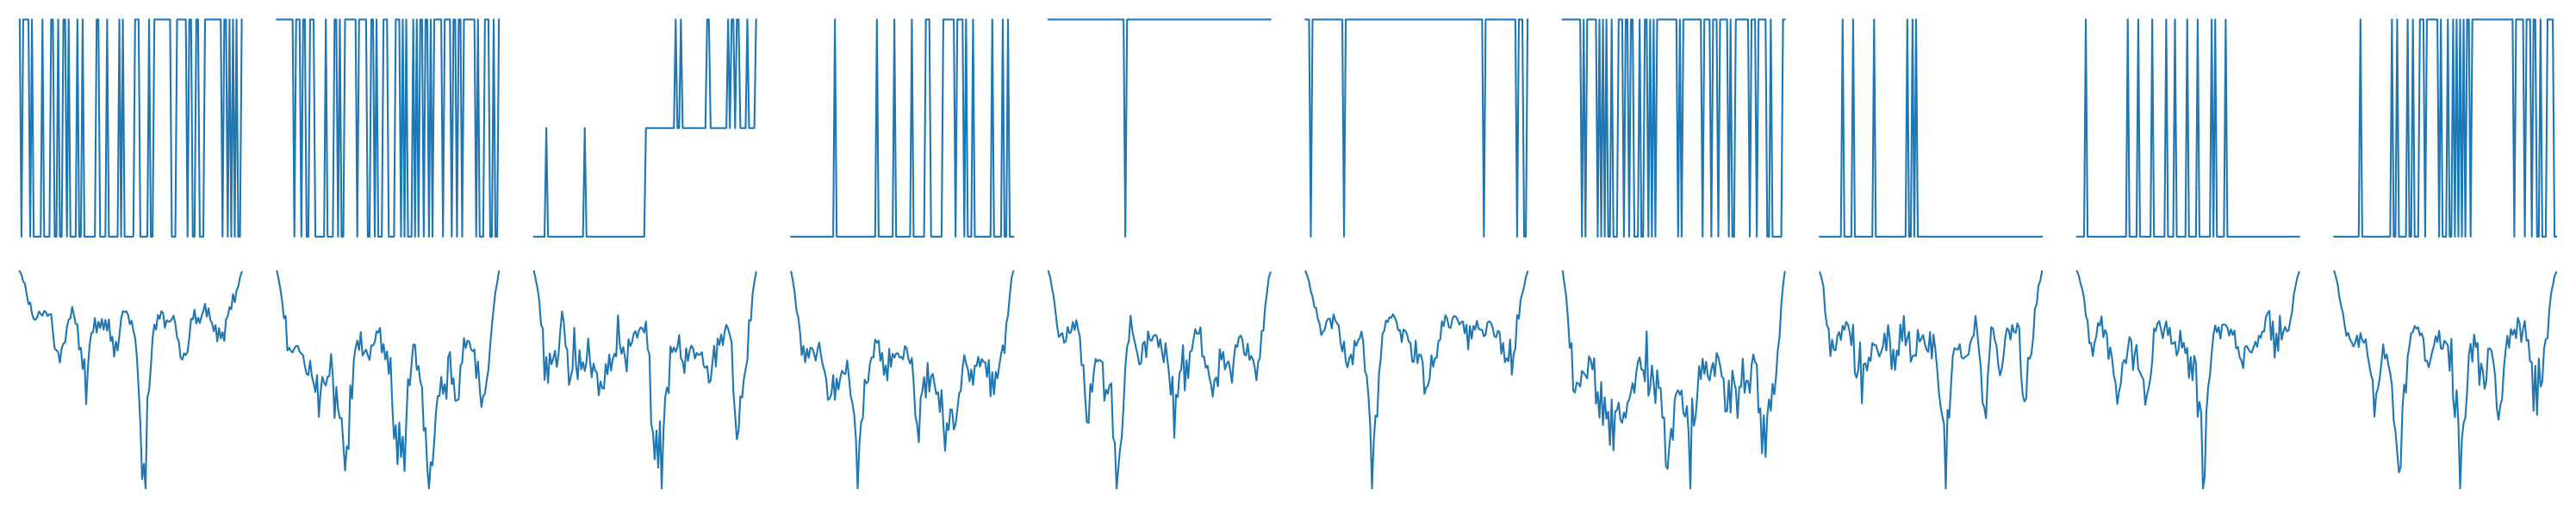

In [ ]:
vae_cnn_CE_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_CE_d60_w128.keras')
visualize_combined(vae_cnn_CE_d60_w128, test_data, latent_dim=60, n=10)

## z-score with mse

In [ ]:
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_w128(60)
dec = decoder_w128(60)
vae_cnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')
vae_cnn_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


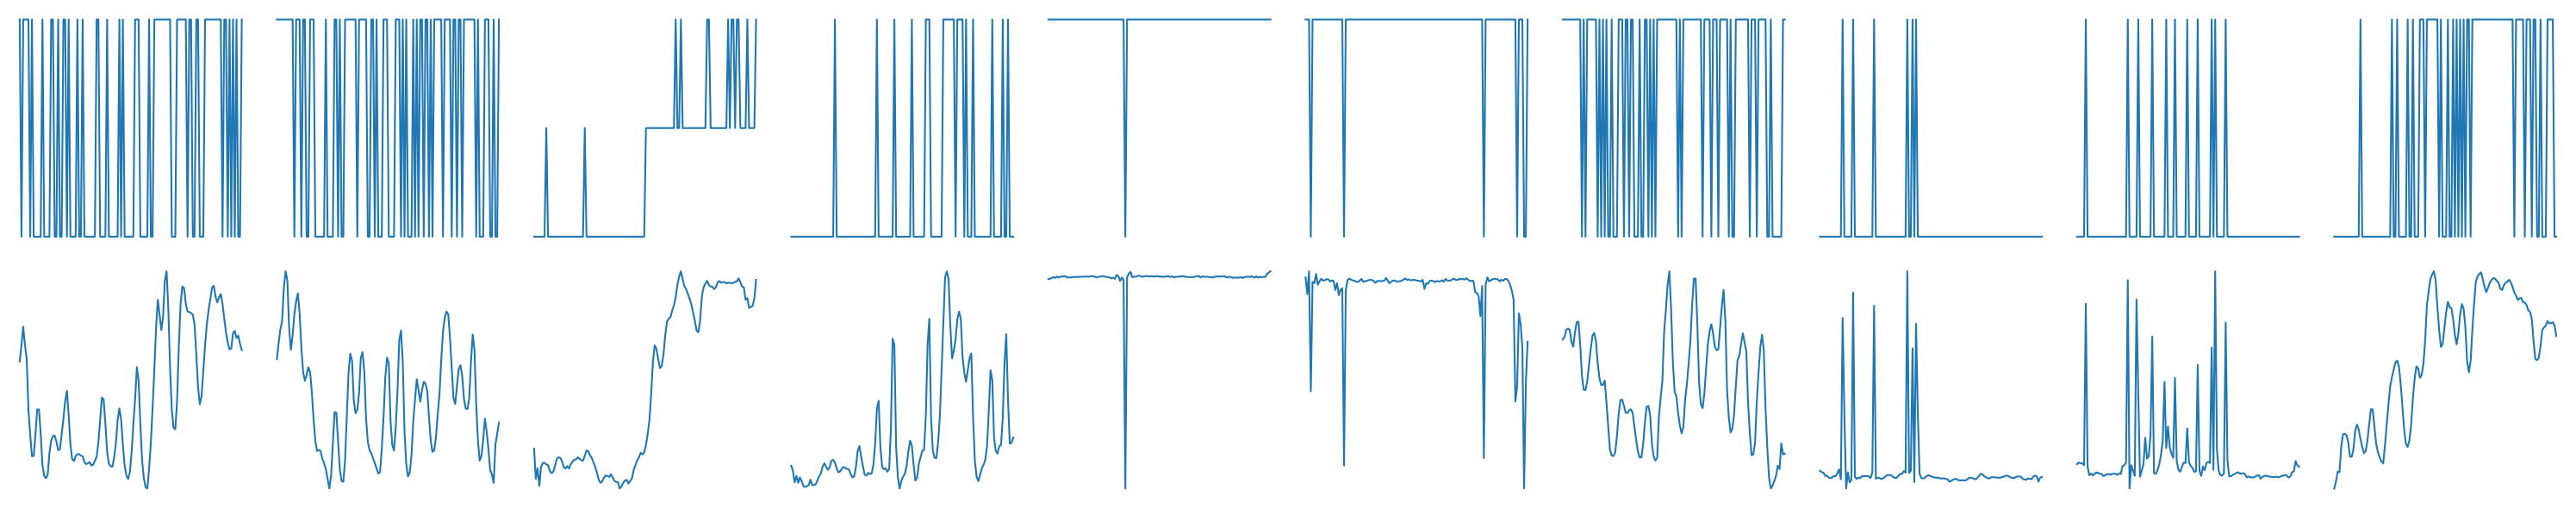

In [ ]:
vae_cnn_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_d60_w128.keras')
visualize_combined(vae_cnn_d60_w128, test_data, latent_dim=60, n=10)

## negative-slope=0.5

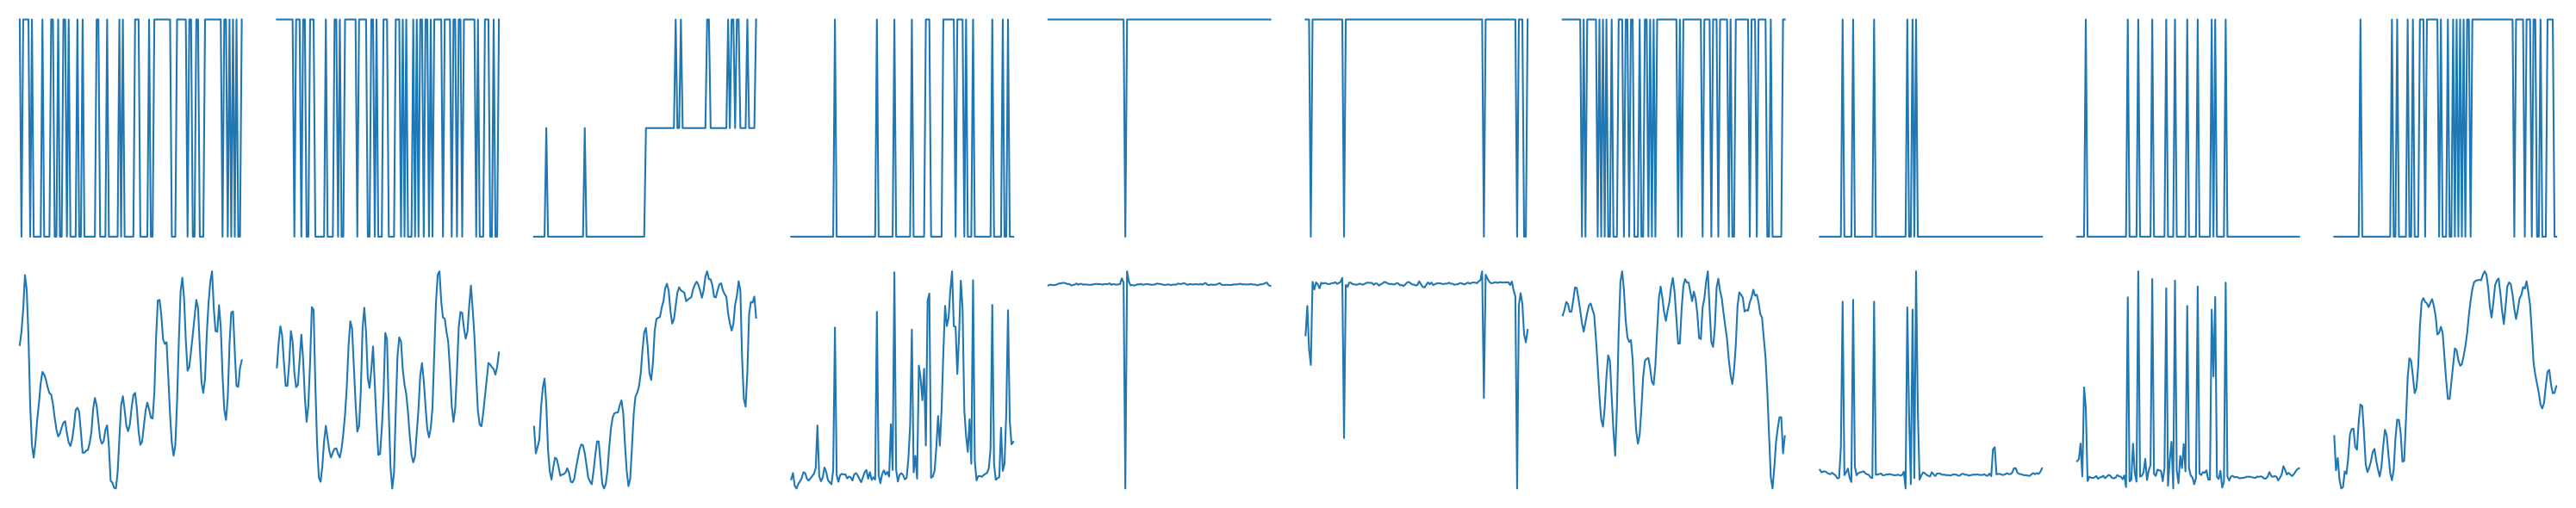

In [ ]:
vae_cnn_slope_05_d60_w128.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_cnn_slope_05_d60_w128.keras')
visualize_combined(vae_cnn_slope_05_d60_w128, test_data, latent_dim=60, n=10)

## Dilated-CNN

### regular

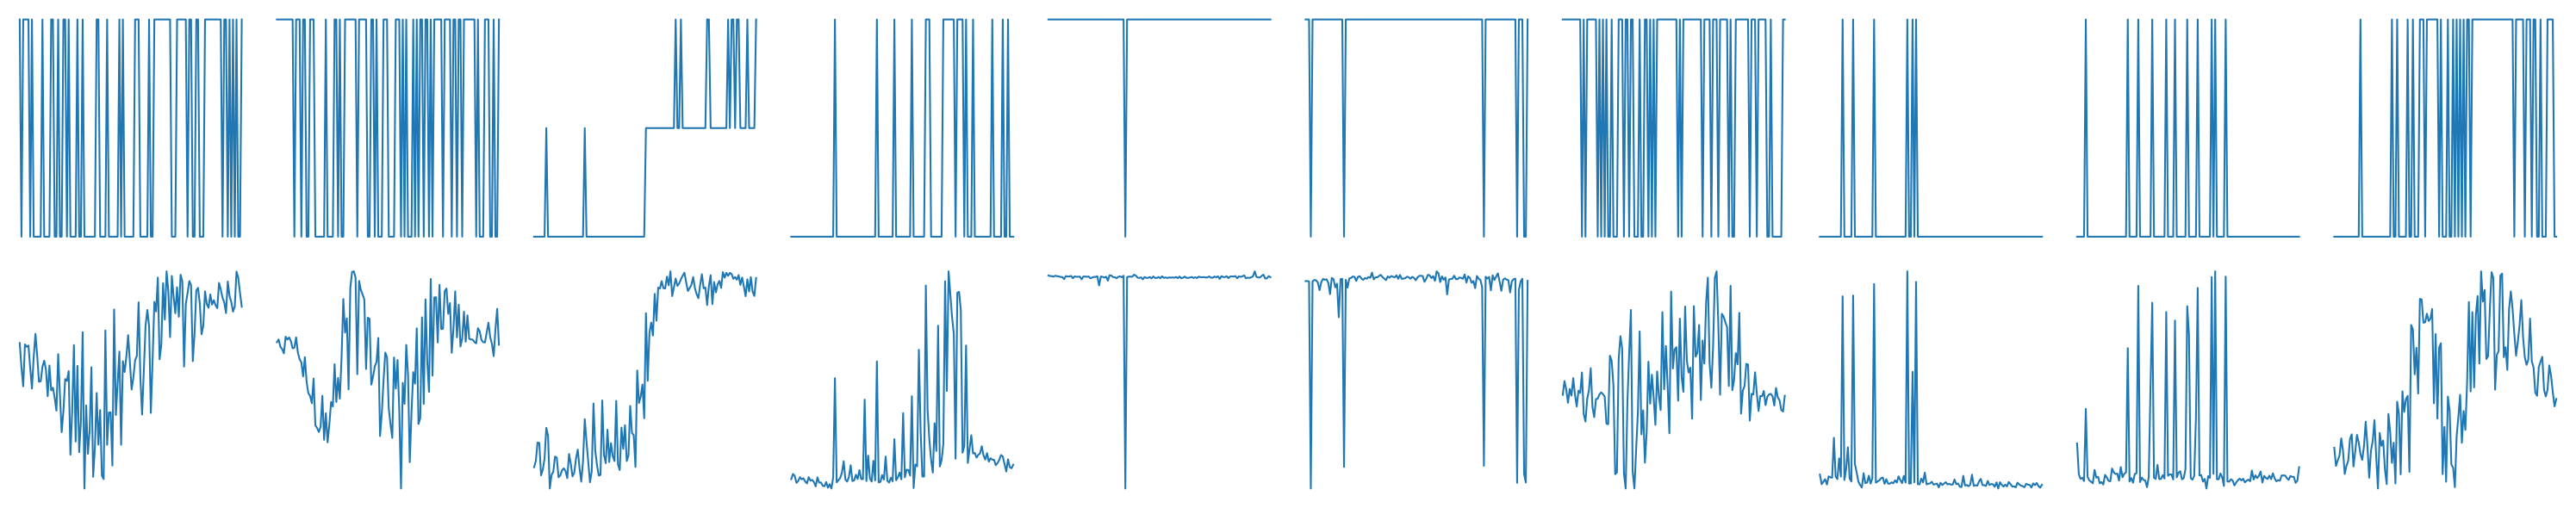

In [ ]:
# vae_cnn_dilated_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_d60_w128.keras')
visualize_combined(vae_cnn_dilated_d60_w128, test_data, latent_dim=60, n=10)

### stream-based

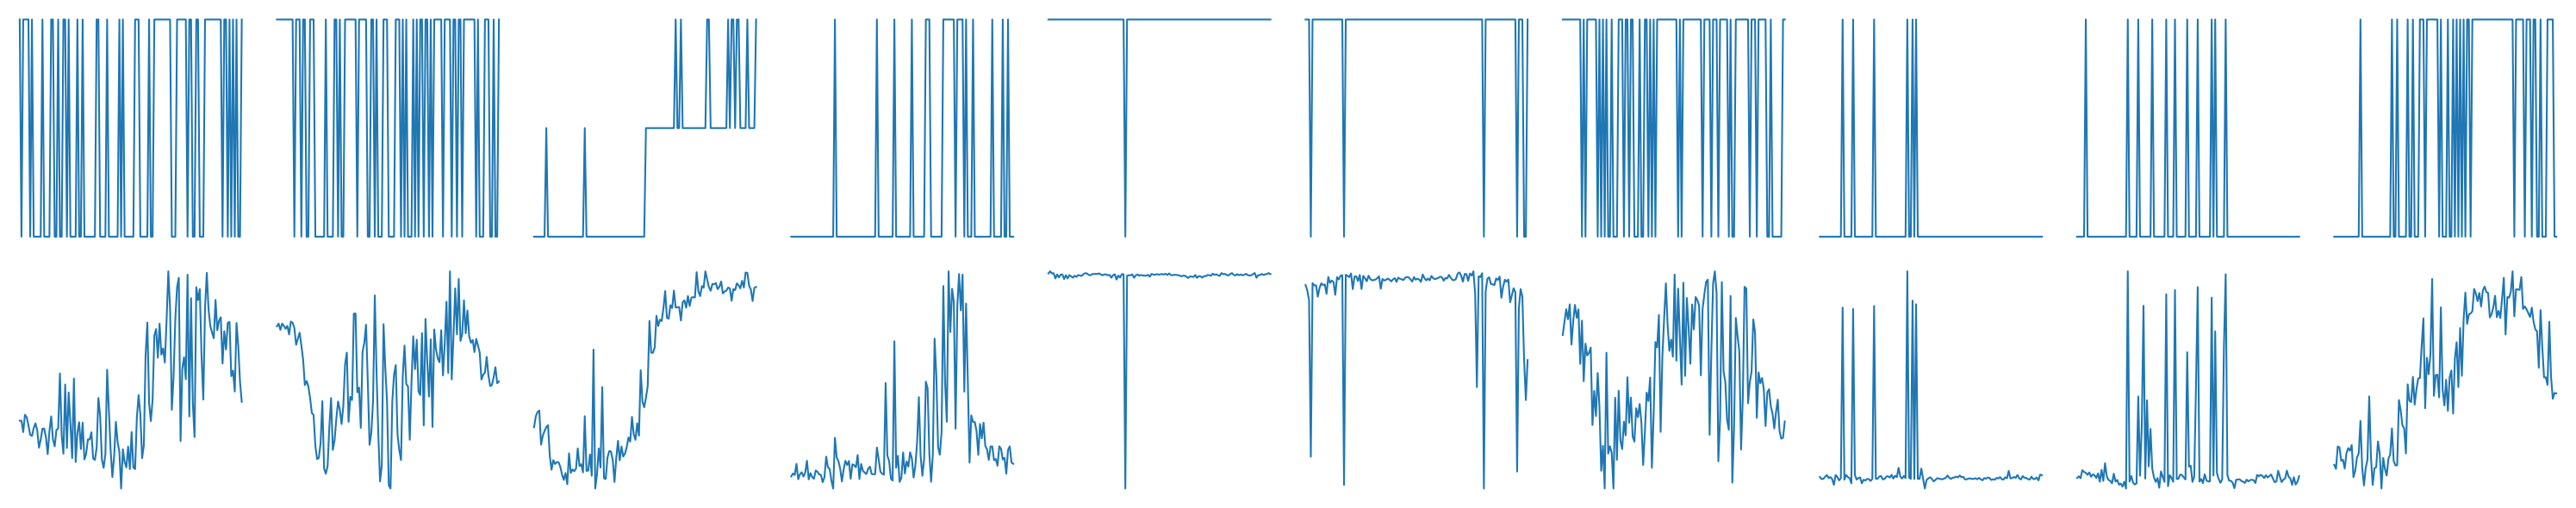

In [ ]:
vae_cnn_dilated_stream_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_d60_w128.keras')
visualize_combined(vae_cnn_dilated_stream_d60_w128, test_data, latent_dim=60, n=10)

### stream-based (channel-based) d=5 in decoder

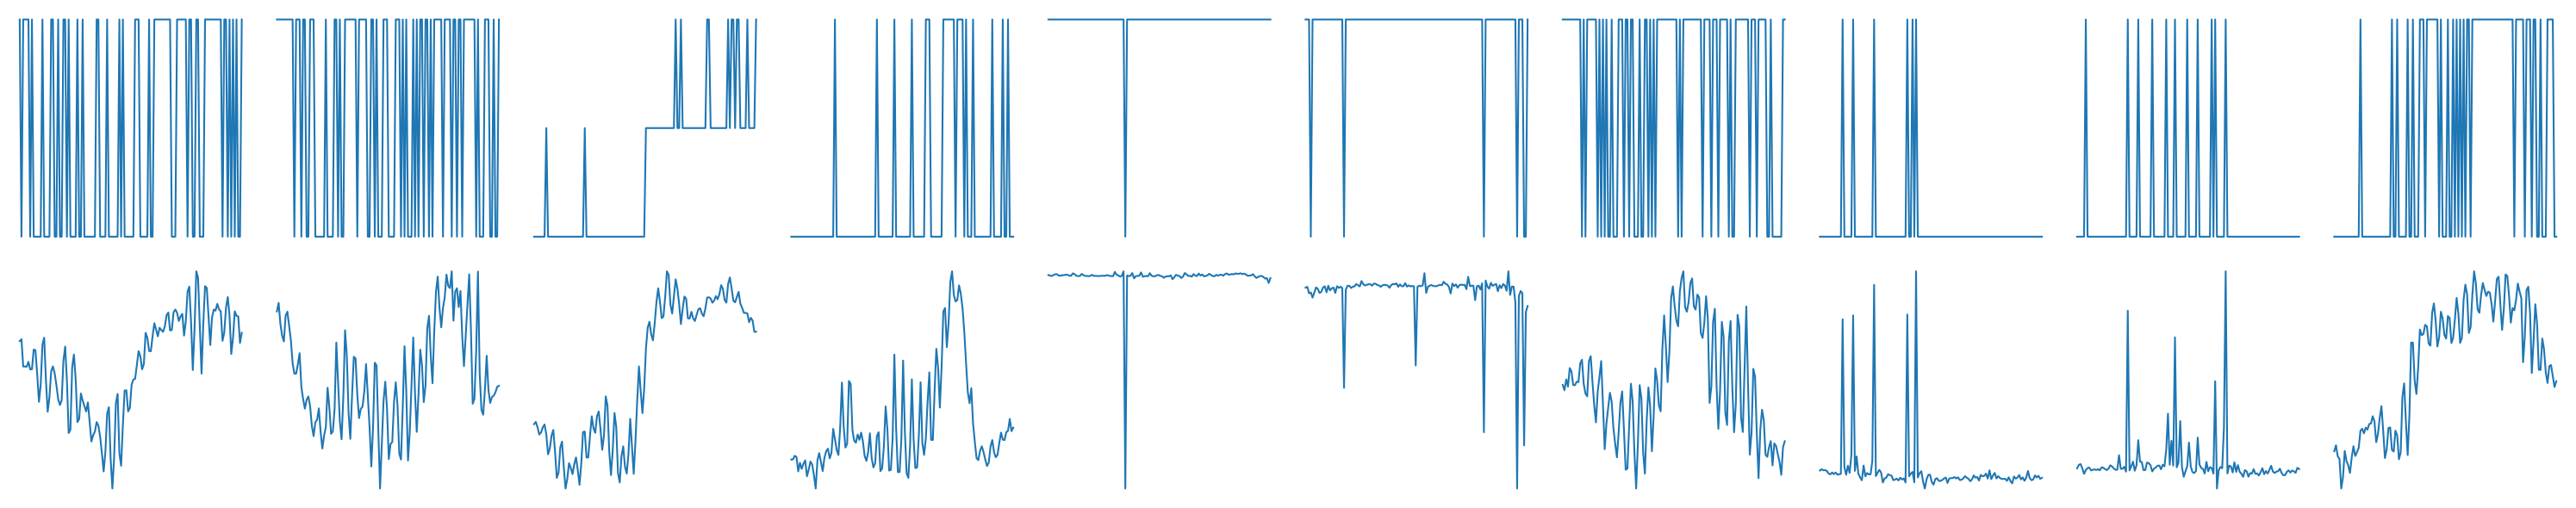

In [ ]:
vae_cnn_dilated_stream_channel_d60_w128.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_channel_d60_w128.keras')
visualize_combined(vae_cnn_dilated_stream_channel_d60_w128, test_data, latent_dim=60, n=10)

### stream-based (channel-based) d=4 in decoder

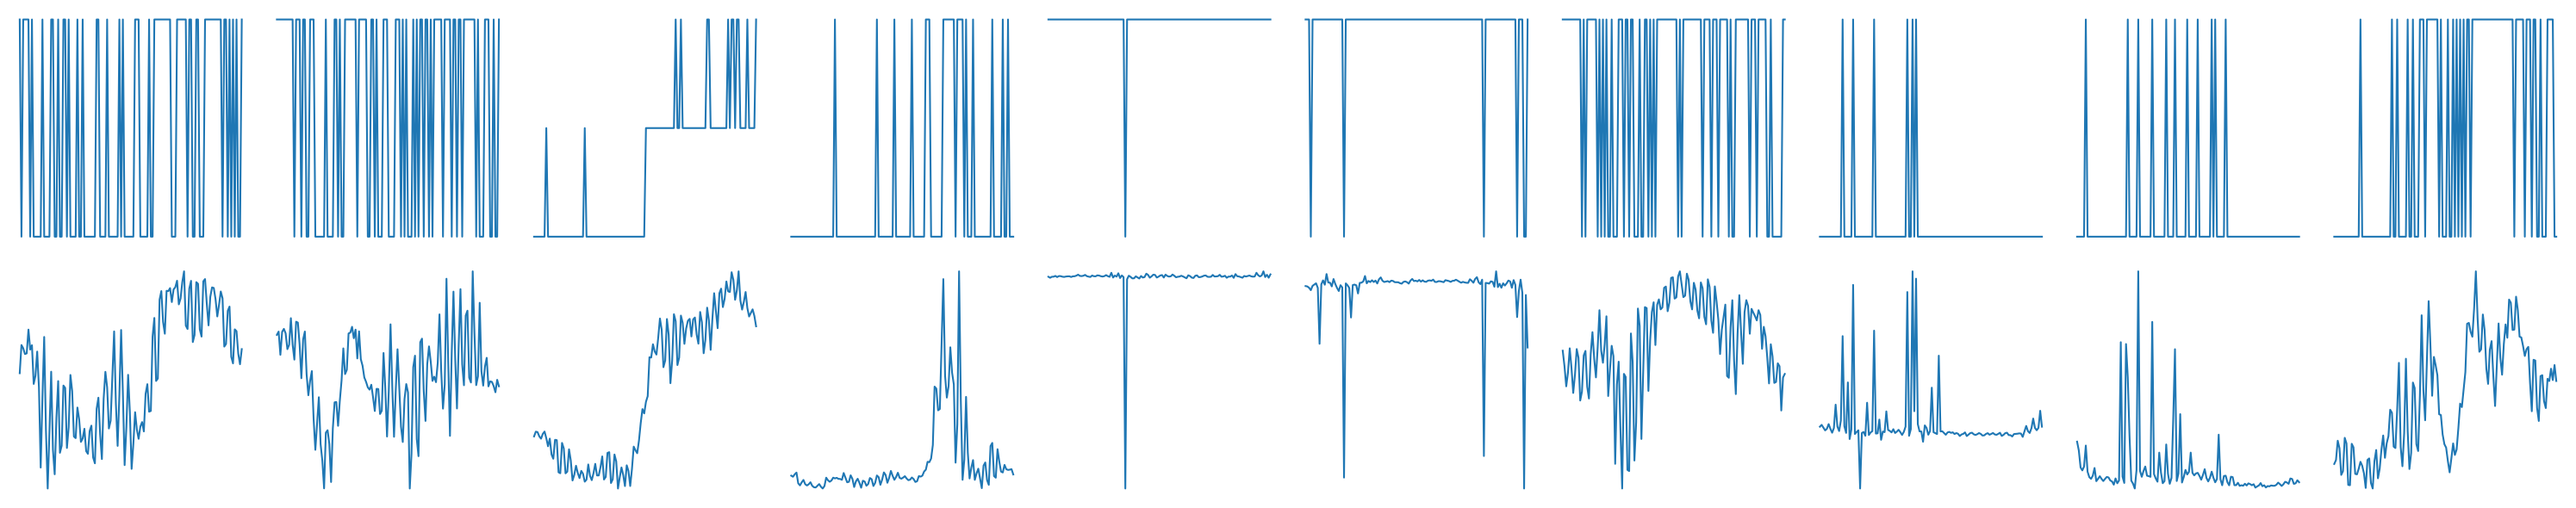

In [ ]:
enc = encoder_dilated_multistream_channel(60)
dec = decoder_dilated(60)
vae = VAE(enc, dec)
vae.load_weights('/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_cnn_dilated_stream_channel_dil4_d60_w128.keras')
visualize_combined(vae, test_data, latent_dim=60, n=10)

## RNN-based

In [ ]:
train_data, test_data = train_test_set(window_size = 128,stride=1)
enc = encoder_gru(60)
dec = decoder_gru(60)
vae_rnn_d60_w128 = train_vae(train_data,test_data,enc, dec,'/content/drive/MyDrive/AutoEncoder (on our data)/VAE on ts models/vae_rnn_d60_w128.keras')

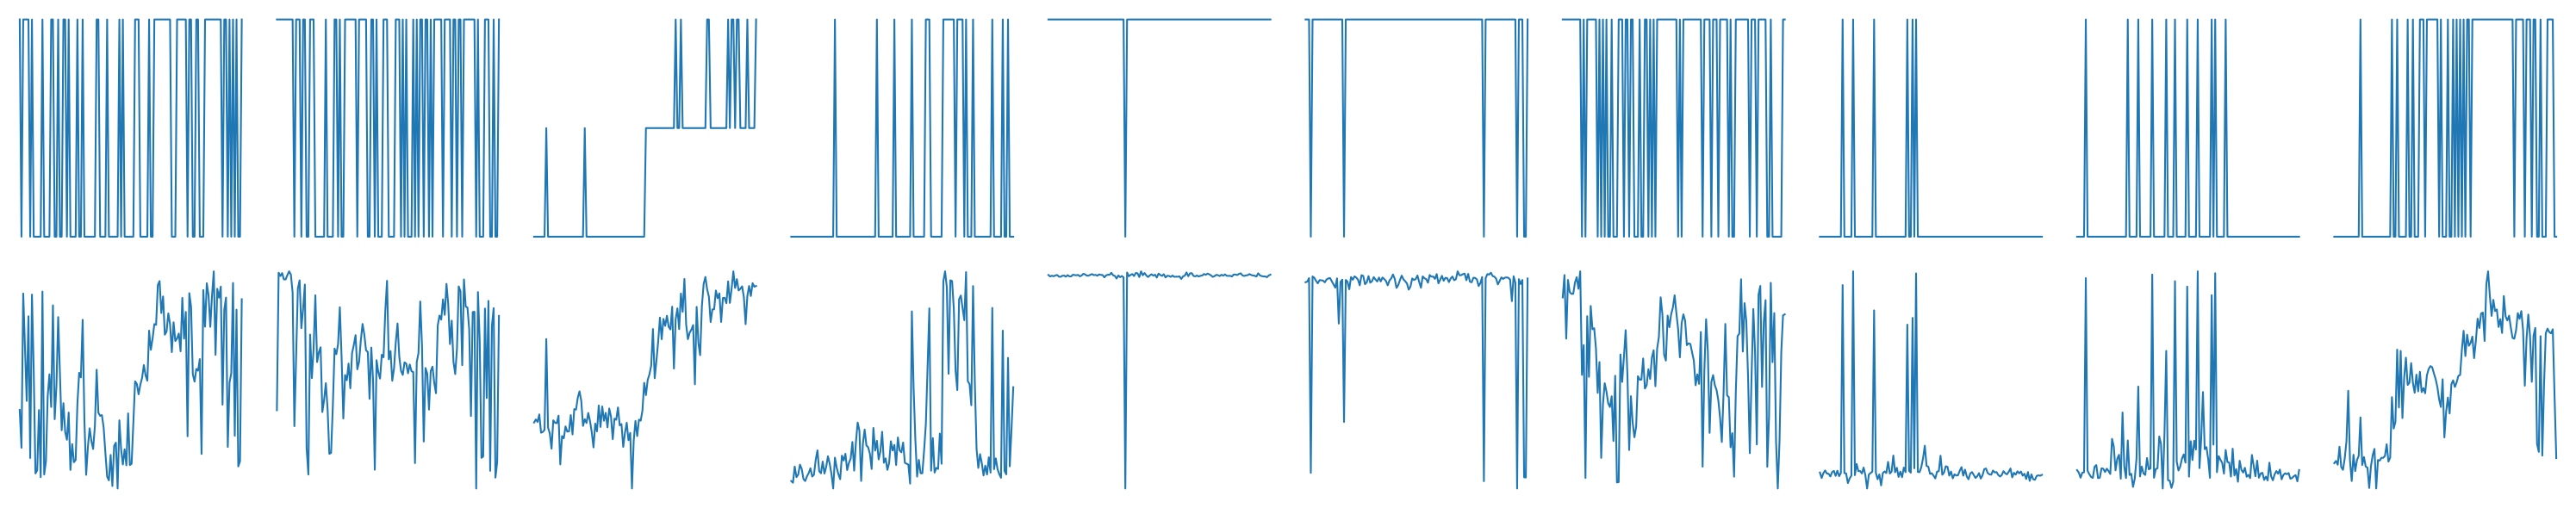

In [ ]:
vae_rnn_d60_w128.load_weights('/content/drive/MyDrive/Fateme Abdollah Zade/SEM/AutoEncoder (on our data)/VAE on ts models/vae_rnn_d60_w128.keras')
visualize_combined(vae_rnn_d60_w128, test_data, latent_dim=60, n=10)

In [ ]:
data1 = np.random.randn(1,2,2,1)
data2 = np.random.randn(1,2,2,1)

In [ ]:
print(data1)

[[[[ 1.35923731]
   [ 0.01489229]]

  [[-0.40325539]
   [-0.01699401]]]]


In [ ]:
print(data2)

[[[[ 1.47806315]
   [-1.74152244]]

  [[ 1.05161173]
   [-0.65418711]]]]


In [ ]:
print(keras.losses.binary_crossentropy(data1, data2))

tf.Tensor(
[[[-5.79022125  0.24003552]
  [22.61780462 -0.27391098]]], shape=(1, 2, 2), dtype=float64)


In [ ]:
sum = ops.sum(
              keras.losses.binary_crossentropy(data1, data2),
              axis=(1,2),
             )

print(sum)

tf.Tensor([16.79370792], shape=(1,), dtype=float64)


# Medium
[link](https://ryanraymartin.medium.com/variational-autoencoders-for-timeseries-data-generation-9e80d1ed425e)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE
from keras import layers, models
import argparse

In [ ]:
def generate_timeseries_data(num_samples, num_timesteps):
    """
    Generate synthetic timeseries data.

    Parameters:
        num_samples (int): Number of samples in the dataset.
        num_timesteps (int): Number of timesteps in each sample.

    Returns:
        np.ndarray: Generated timeseries data with shape (num_samples, num_timesteps).
    """
    return np.random.rand(num_samples, num_timesteps)

In [ ]:
class VAE(models.Model):
    """
    Variational Autoencoder (VAE) model.

    Parameters:
        input_dim (int): Dimension of input timeseries data.
        latent_dim (int): Dimension of the latent space.
    """

    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        encoder_input = layers.Input(shape=(self.input_dim,))
        x = layers.Dense(128, activation='relu')(encoder_input)
        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)
        encoder_output = layers.Lambda(self.sample_z, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        return models.Model(encoder_input, [z_mean, z_log_var, encoder_output])  # Ensure to return all three outputs

    def build_decoder(self):
        decoder_input = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(128, activation='relu')(decoder_input)
        decoder_output = layers.Dense(self.input_dim, activation='sigmoid')(x)
        return models.Model(decoder_input, decoder_output)

    def sample_z(self, args):
        z_mean, z_log_var = args
        batch_size = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)  # Correctly unpack all three outputs
        reconstructions = self.decoder(z)
        return reconstructions, z_mean, z_log_var


In [ ]:
def vae_loss(y_true, y_pred, z_mean, z_log_var):
    """
    Define the loss function for the VAE model.

    Parameters:
        y_true (tf.Tensor): Ground truth values.
        y_pred (tf.Tensor): Predicted values (reconstructed data).
        z_mean (tf.Tensor): Mean of the latent variable.
        z_log_var (tf.Tensor): Log variance of the latent variable.

    Returns:
        tf.Tensor: Total loss (reconstruction loss + KL divergence).
    """
    mse_loss = tf.keras.losses.MeanSquaredError()
    recon_loss = mse_loss(y_true, y_pred)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return recon_loss + kl_loss


In [ ]:
def main(num_samples, num_timesteps, latent_dim, epochs, batch_size):
    # Generate synthetic timeseries data
    data = generate_timeseries_data(num_samples, num_timesteps)

    # Normalize the data
    data_mean = data.mean()
    data_std = data.std()
    data_normalized = (data - data_mean) / data_std

    # Create VAE model
    vae = VAE(num_timesteps, latent_dim)
    vae.compile(optimizer='adam')  # Remove the custom loss from here

    # Custom training loop
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            reconstructions, z_mean, z_log_var = vae(data_normalized)
            loss = vae_loss(data_normalized, reconstructions, z_mean, z_log_var)  # Pass the outputs to the loss function

        grads = tape.gradient(loss, vae.trainable_variables)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')  # Print the loss for each epoch

    # Reduce dimensionality of timeseries using the trained encoder
    z_mean, z_log_var, encoded_data = vae.encoder.predict(data_normalized)  # Unpack the outputs to get the encoded data

    # Set the style of the plots
    sns.set(style="whitegrid")

    plt.figure(figsize=(12, 10))

    # Plot the original timeseries data
    plt.subplot(4, 2, 1)
    plt.title("Original Timeseries Data", fontsize=16)
    for i in range(num_samples):
        plt.plot(data[i], alpha=0.5, label=f"Sample {i+1}")
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    # Plot the encoded data in 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=2, random_state=42)
    encoded_data_tsne = tsne.fit_transform(encoded_data)

    plt.subplot(4, 2, 2)
    plt.title("Encoded Data (t-SNE)", fontsize=16)
    plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1],
                alpha=0.7, s=100, c=range(num_samples), cmap='viridis')
    plt.colorbar(label='Sample Index')
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True)

    # Plot the encoded data in 2D
    plt.subplot(4, 2, 3)
    plt.title("Latent Space Representation", fontsize=16)
    plt.scatter(encoded_data[:, 0], encoded_data[:, 1],
                alpha=0.7, s=100, c=range(num_samples), cmap='viridis')
    plt.colorbar(label='Sample Index')
    plt.xlabel("Latent Dimension 1", fontsize=12)
    plt.ylabel("Latent Dimension 2", fontsize=12)
    plt.grid(True)

    # Plot the original timeseries data after applying t-SNE
    decoded_data_tsne = vae.decoder.predict(encoded_data_tsne)
    plt.subplot(4, 2, 4)
    plt.title("Reconstructed Timeseries Data from t-SNE", fontsize=16)
    for i in range(num_samples):
        plt.plot(decoded_data_tsne[i], alpha=0.5, label=f"Sample {i+1}")
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epoch 1, Loss: 2.1020796298980713
Epoch 2, Loss: 1.8610973358154297
Epoch 3, Loss: 1.6747417449951172
Epoch 4, Loss: 1.533919334411621
Epoch 5, Loss: 1.4118841886520386
Epoch 6, Loss: 1.3233788013458252
Epoch 7, Loss: 1.2876449823379517
Epoch 8, Loss: 1.2553095817565918
Epoch 9, Loss: 1.2520188093185425
Epoch 10, Loss: 1.2579363584518433
Epoch 11, Loss: 1.2579545974731445
Epoch 12, Loss: 1.2669445276260376
Epoch 13, Loss: 1.2663346529006958
Epoch 14, Loss: 1.2665349245071411
Epoch 15, Loss: 1.259614109992981
Epoch 16, Loss: 1.2768042087554932
Epoch 17, Loss: 1.2565428018569946
Epoch 18, Loss: 1.267061471939087
Epoch 19, Loss: 1.2522729635238647
Epoch 20, Loss: 1.2644380331039429
Epoch 21, Loss: 1.2369242906570435
Epoch 22, Loss: 1.2503398656845093
Epoch 23, Loss: 1.234980583190918
Epoch 24, Loss: 1.2294578552246094
Epoch 25, Loss: 1.2216098308563232
Epoch 26, Loss: 1.1922917366027832
Epoch 27, Loss: 1.2131271362304688
Epoch 28, Loss: 1.230451226234436
Epoch 29, Loss: 1.191757321357727


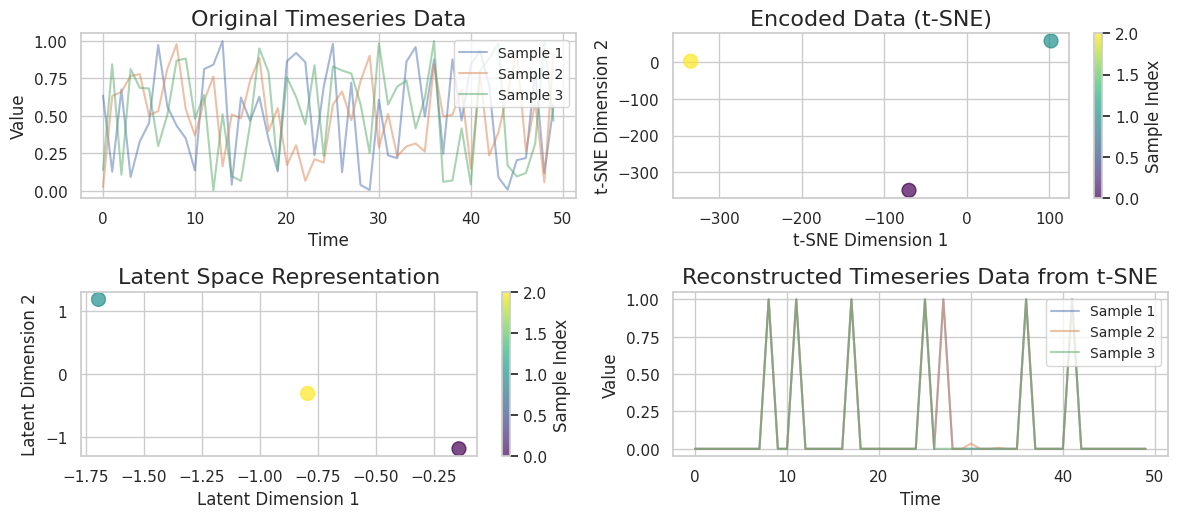

In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Variational Autoencoder for Timeseries Data")
    parser.add_argument("--num_samples", type=int, default=3, help="Number of samples in the dataset")
    parser.add_argument("--num_timesteps", type=int, default=50, help="Number of timesteps in each sample")
    parser.add_argument("--latent_dim", type=int, default=2, help="Dimension of the latent space")
    parser.add_argument("--epochs", type=int, default=300, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size for training")

    args = parser.parse_args(args=[])
    main(args.num_samples, args.num_timesteps, args.latent_dim, args.epochs, args.batch_size)
